# Fashion-MNIST Classification

 1. Reading the dataset and creating dataloaders
 
 2. Creating the model
      
 3. Creating the loss and optimizer
      
 4. The training script
 
 5. Final model accuracy on Fashion-MNIST Validation Set

In [1]:
# Importing all necessary packages

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
import torchvision
from torchvision import transforms
from einops import rearrange

## 1. Reading the dataset and creating dataloaders

In [2]:
def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [3]:
batch_size = 16
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 2. Creating the model

The model is an expansion of the basic MLP. It consists of a stem which takes as input an image from the Fashion-MNIST dataset, and divides this into 4 non-overlapping patches. The resulting tensor is then fed into a linear layer before transposition.

The backbone consists of one blocks containing two sets of two linear layers separated by another transpose.

The classifier consists of an averaging layer followed by a single linear layer, resulting in 10 outputs, matching the 10 classes in the dataset.

In [4]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, image_size, patch_size, vector_dim):
        super(Net, self).__init__()
        assert image_size % patch_size == 0
        num_patches = (image_size // patch_size) ** 2
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.image_size = image_size
        self.patch_size = patch_size
        self.vector_dim = vector_dim
        self.LinearStem = nn.Linear(patch_size ** 2, vector_dim)
        self.Linear1 = nn.Linear(num_patches, num_hidden)
        self.Linear2 = nn.Linear(num_hidden, num_hidden)
        self.Linear3 = nn.Linear(vector_dim, num_hidden)
        self.Classifier = nn.Linear(num_hidden, num_outputs)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        
        # STEM
    
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        x = self.LinearStem(x)
        
        x = torch.transpose(x,1,2)
        
        # BACKBONE
        
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.Linear2(x)
        x = torch.transpose(x,1,2)
        x = self.Linear3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.Linear2(x)
        
        # CLASSIFIER
        
        x = torch.mean(x,1)
        out = self.Classifier(x)
        return out

In [5]:
num_inputs, num_hidden, num_outputs, image_size, patch_size, vector_dim = 784, 256, 10, 28, 14, 128
net = Net(num_inputs, num_hidden, num_outputs, image_size, patch_size, vector_dim)

## 3. Creating the loss and optimizer

In [6]:
loss = nn.CrossEntropyLoss()
lr, wd = 0.1, 0

optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

## 4. The training script

In [7]:
import collections
from collections import defaultdict
from IPython import display
import math
from matplotlib import pyplot as plt
import os
import pandas as pd
import random
import re
import shutil
import sys
import tarfile
import time
import requests
import zipfile
import hashlib
d2l = sys.modules[__name__]
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms


def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')


def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4


def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))


def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)        
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))


def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]


class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def train_epoch_ch3(net, train_iter, loss, updater):
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y),
                       y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]


class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(7, 5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

    
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

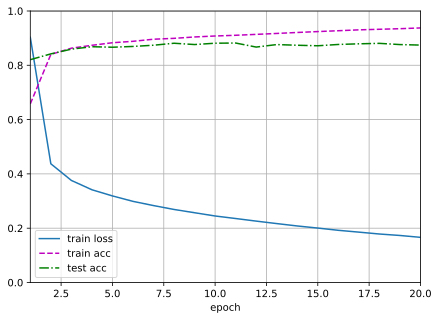

In [8]:
num_epochs = 20
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

## 5. Final model accuracy on Fashion-MNIST Validation Set

In [9]:
evaluate_accuracy(net, test_iter)

0.8744